In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import pairwise_distances, silhouette_score, davies_bouldin_score
from sklearn.manifold import MDS
from scipy.stats import chi2_contingency
import itertools
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

df = pd.read_csv(r'C:\Users\joeto\OneDrive\Desktop\m2\data mining\archive (4)\Covid Data.csv')
df = df.replace(2, 0)

print(df.head())
print(len(df))


   USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  INTUBED  PNEUMONIA  \
0      0             1    1             1  03/05/2020       97          1   
1      0             1    0             1  03/06/2020       97          1   
2      0             1    0             0  09/06/2020        1          0   
3      0             1    1             1  12/06/2020       97          0   
4      0             1    0             1  21/06/2020       97          0   

   AGE  PREGNANT  DIABETES  ...  ASTHMA  INMSUPR  HIPERTENSION  OTHER_DISEASE  \
0   65         0         0  ...       0        0             1              0   
1   72        97         0  ...       0        0             1              0   
2   55        97         1  ...       0        0             0              0   
3   53         0         0  ...       0        0             0              0   
4   68        97         1  ...       0        0             1              0   

   CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  TOBACCO

In [2]:
df_copy = df.copy()
df_copy['IS_DEAD'] = df_copy['DATE_DIED'].apply(lambda x: 1 if x != '9999-99-99' else 0)
label_encoder = LabelEncoder()
df_copy['AGE_0_18'] = ((df_copy['AGE'] >= 0) & (df_copy['AGE'] <= 18)).astype(int)
df_copy['AGE_19_35'] = ((df_copy['AGE'] > 18) & (df_copy['AGE'] <= 35)).astype(int)
df_copy['AGE_36_50'] = ((df_copy['AGE'] > 35) & (df_copy['AGE'] <= 50)).astype(int)
df_copy['AGE_51_65'] = ((df_copy['AGE'] > 50) & (df_copy['AGE'] <= 65)).astype(int)
df_copy['AGE_66_PLUS'] = (df_copy['AGE'] > 65).astype(int)

print(df_copy.head())


   USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  INTUBED  PNEUMONIA  \
0      0             1    1             1  03/05/2020       97          1   
1      0             1    0             1  03/06/2020       97          1   
2      0             1    0             0  09/06/2020        1          0   
3      0             1    1             1  12/06/2020       97          0   
4      0             1    0             1  21/06/2020       97          0   

   AGE  PREGNANT  DIABETES  ...  RENAL_CHRONIC  TOBACCO  CLASIFFICATION_FINAL  \
0   65         0         0  ...              0        0                     3   
1   72        97         0  ...              1        0                     5   
2   55        97         1  ...              0        0                     3   
3   53         0         0  ...              0        0                     7   
4   68        97         1  ...              0        0                     3   

   ICU  IS_DEAD  AGE_0_18  AGE_19_35  AGE_36_50  A

In [3]:


def display_description(df):
    description = df.describe(include='all')
    print("Description de toutes les colonnes :")
    print(description)

def encode_non_numeric_columns(df):
    label_encoder = LabelEncoder()
    non_numeric_columns = df.select_dtypes(include=['object']).columns
    
    for col in non_numeric_columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    return df

def display_min_max(df, step_name=""):
    print(f"\nValeurs minimales {step_name} :")
    print(df.min())
    
    print(f"\nValeurs maximales {step_name} :")
    print(df.max())

def replace_anomalous_values(df, anomalous_values, columns_to_clean):
    df[columns_to_clean] = df[columns_to_clean].replace(anomalous_values, pd.NA)
    return df

def display_data_preview(df):
    print("\nAperçu des données nettoyées :")
    print(df.head())

def clean_data(df):
    display_description(df)    
    df = encode_non_numeric_columns(df)    
    display_min_max(df, "avant nettoyage")    
    anomalous_values = [97, 98, 99]
    columns_to_clean = ['INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 
                        'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 
                        'OBESITY', 'RENAL_CHRONIC', 'TOBACCO','ICU']
    df = replace_anomalous_values(df, anomalous_values, columns_to_clean)    
    display_min_max(df, "après nettoyage")   
    display_data_preview(df)

clean_data(df_copy)


Description de toutes les colonnes :
               USMER  MEDICAL_UNIT           SEX  PATIENT_TYPE   DATE_DIED  \
count   1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06     1048575   
unique           NaN           NaN           NaN           NaN         401   
top              NaN           NaN           NaN           NaN  9999-99-99   
freq             NaN           NaN           NaN           NaN      971633   
mean    3.678058e-01  8.980243e+00  5.007405e-01  8.092354e-01         NaN   
std     4.822084e-01  3.723969e+00  4.999997e-01  3.929041e-01         NaN   
min     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00         NaN   
25%     0.000000e+00  4.000000e+00  0.000000e+00  1.000000e+00         NaN   
50%     0.000000e+00  1.200000e+01  1.000000e+00  1.000000e+00         NaN   
75%     1.000000e+00  1.200000e+01  1.000000e+00  1.000000e+00         NaN   
max     1.000000e+00  1.300000e+01  1.000000e+00  1.000000e+00         NaN   

             INTUBED     P

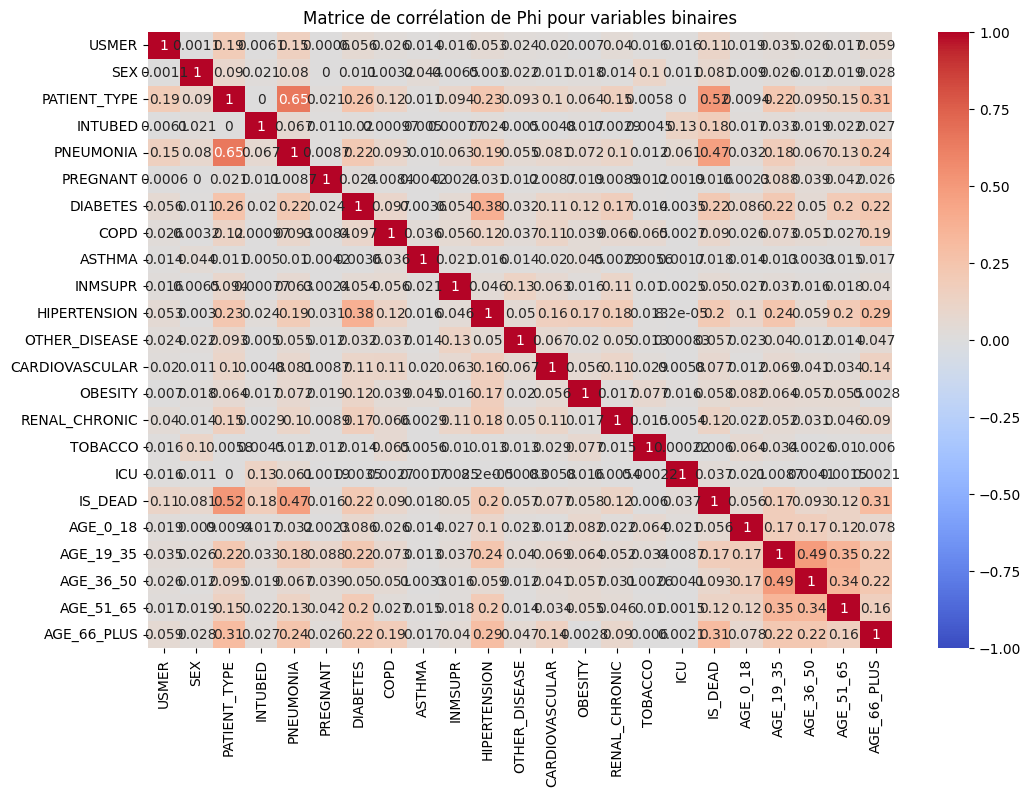

In [52]:


def phi_correlation_matrix(df):
    binary_cols = [col for col in df.columns if df[col].nunique() == 2  ]  
    binary_df = df[binary_cols]
    corr_matrix = pd.DataFrame(np.zeros((len(binary_cols), len(binary_cols))),
                               index=binary_cols, columns=binary_cols)
    for col1, col2 in itertools.combinations(binary_df.columns, 2):
        contingency_table = pd.crosstab(binary_df[col1], binary_df[col2])
        chi2, _, _, _ = chi2_contingency(contingency_table)
        phi_corr = np.sqrt(chi2 / binary_df.shape[0])
        corr_matrix.loc[col1, col2] = phi_corr
        corr_matrix.loc[col2, col1] = phi_corr
    np.fill_diagonal(corr_matrix.values, 1)
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Matrice de corrélation de Phi pour variables binaires')
    plt.show()
    return corr_matrix
corr_matrix =phi_correlation_matrix(df_copy)


In [53]:

def filter_correlations(corr_matrix, threshold, age_columns):
    results = []
    for col1, col2 in itertools.combinations(corr_matrix.columns, 2):
        if col1 in age_columns and col2 in age_columns:
            continue  
        corr_value = corr_matrix.loc[col1, col2]
        if abs(corr_value) > threshold: 
            results.append((col1, col2, corr_value))
    filtered_df = pd.DataFrame(results, columns=['Variable 1', 'Variable 2', 'Correlation'])    
    return filtered_df

age_columns = ['AGE_19_35', 'AGE_36_50', 'AGE_51_65', 'AGE_66_PLUS']
# corr_matrix = phi_correlation_matrix(df_copy)  
filtered_correlations = filter_correlations(corr_matrix, threshold=0.3, age_columns=age_columns) 
print(filtered_correlations)


     Variable 1    Variable 2  Correlation
0  PATIENT_TYPE     PNEUMONIA     0.648543
1  PATIENT_TYPE       IS_DEAD     0.515578
2  PATIENT_TYPE   AGE_66_PLUS     0.305249
3     PNEUMONIA       IS_DEAD     0.467942
4      DIABETES  HIPERTENSION     0.378438
5       IS_DEAD   AGE_66_PLUS     0.307064


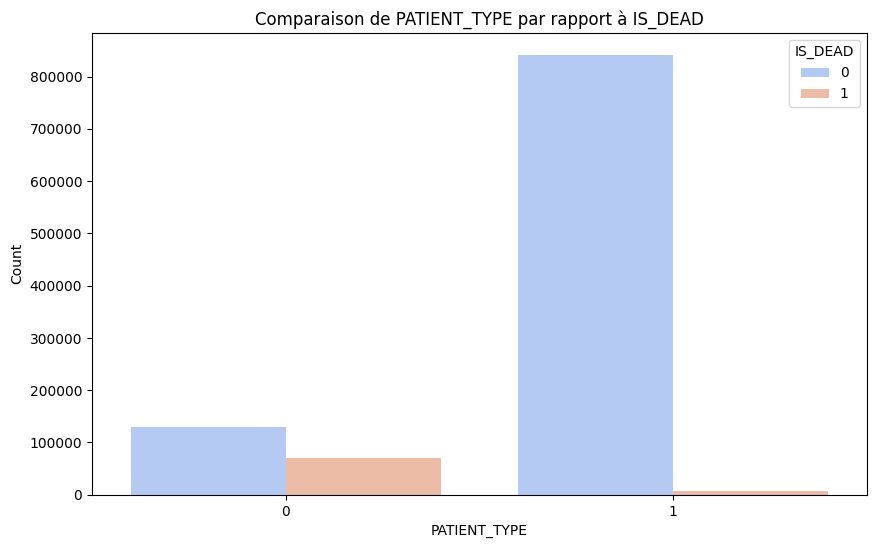

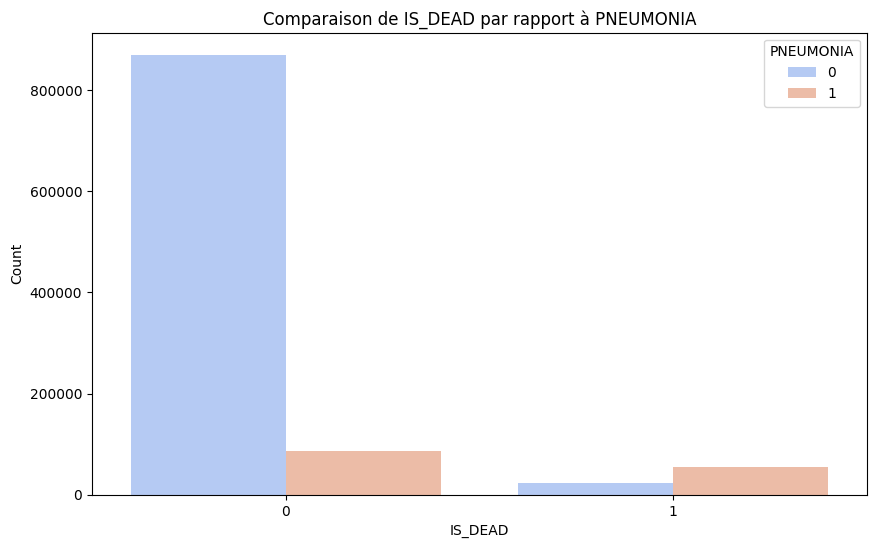

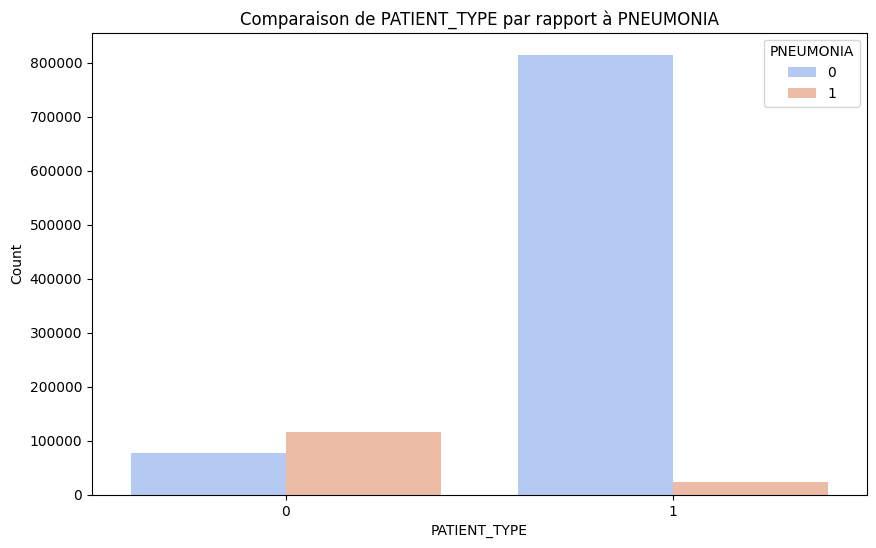

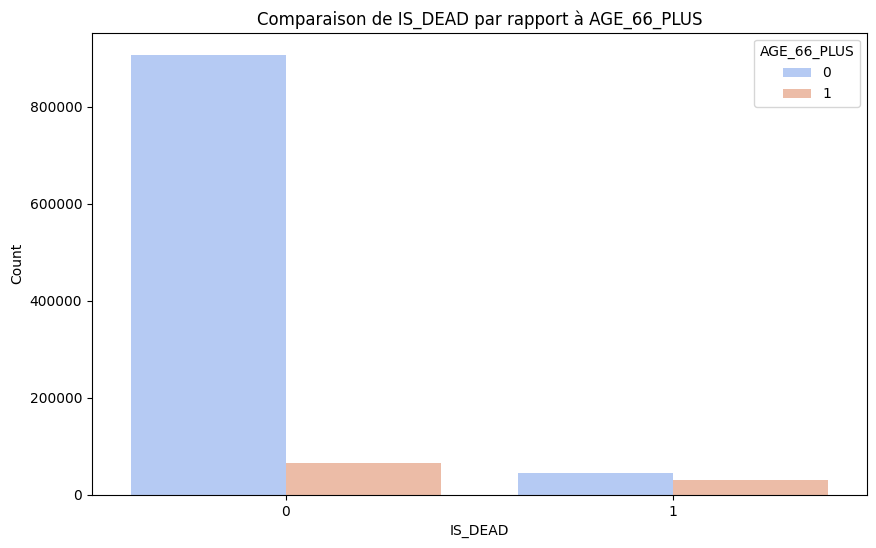

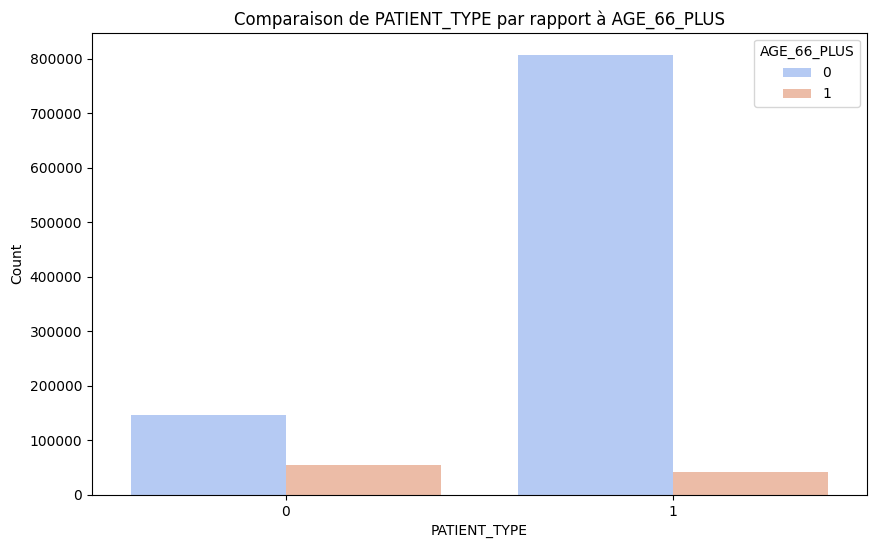

In [6]:

def visualize_correlation(df, var1, var2):
    if df[var1].isnull().any() or df[var2].isnull().any():
        df = df.dropna(subset=[var1, var2])  
    plt.figure(figsize=(10, 6))
    if df[var1].nunique() <= 2 and df[var2].nunique() <= 2:
        sns.countplot(data=df, x=var1, hue=var2, palette='coolwarm')
        plt.title(f'Comparaison de {var1} par rapport à {var2}')
        plt.xlabel(var1)
        plt.ylabel('Count')
    else:
        sns.scatterplot(data=df, x=var1, y=var2, hue=var2, palette='coolwarm', alpha=0.7)
        plt.title(f'Relation entre {var1} et {var2}')
        plt.xlabel(var1)
        plt.ylabel(var2)    
    plt.legend(title=var2)
    plt.show()

visualize_correlation(df_copy, 'PATIENT_TYPE', 'IS_DEAD')
visualize_correlation(df_copy, 'IS_DEAD', 'PNEUMONIA')
visualize_correlation(df_copy, 'PATIENT_TYPE', 'PNEUMONIA')
visualize_correlation(df_copy, 'IS_DEAD', 'AGE_66_PLUS')
visualize_correlation(df_copy, 'PATIENT_TYPE', 'AGE_66_PLUS')


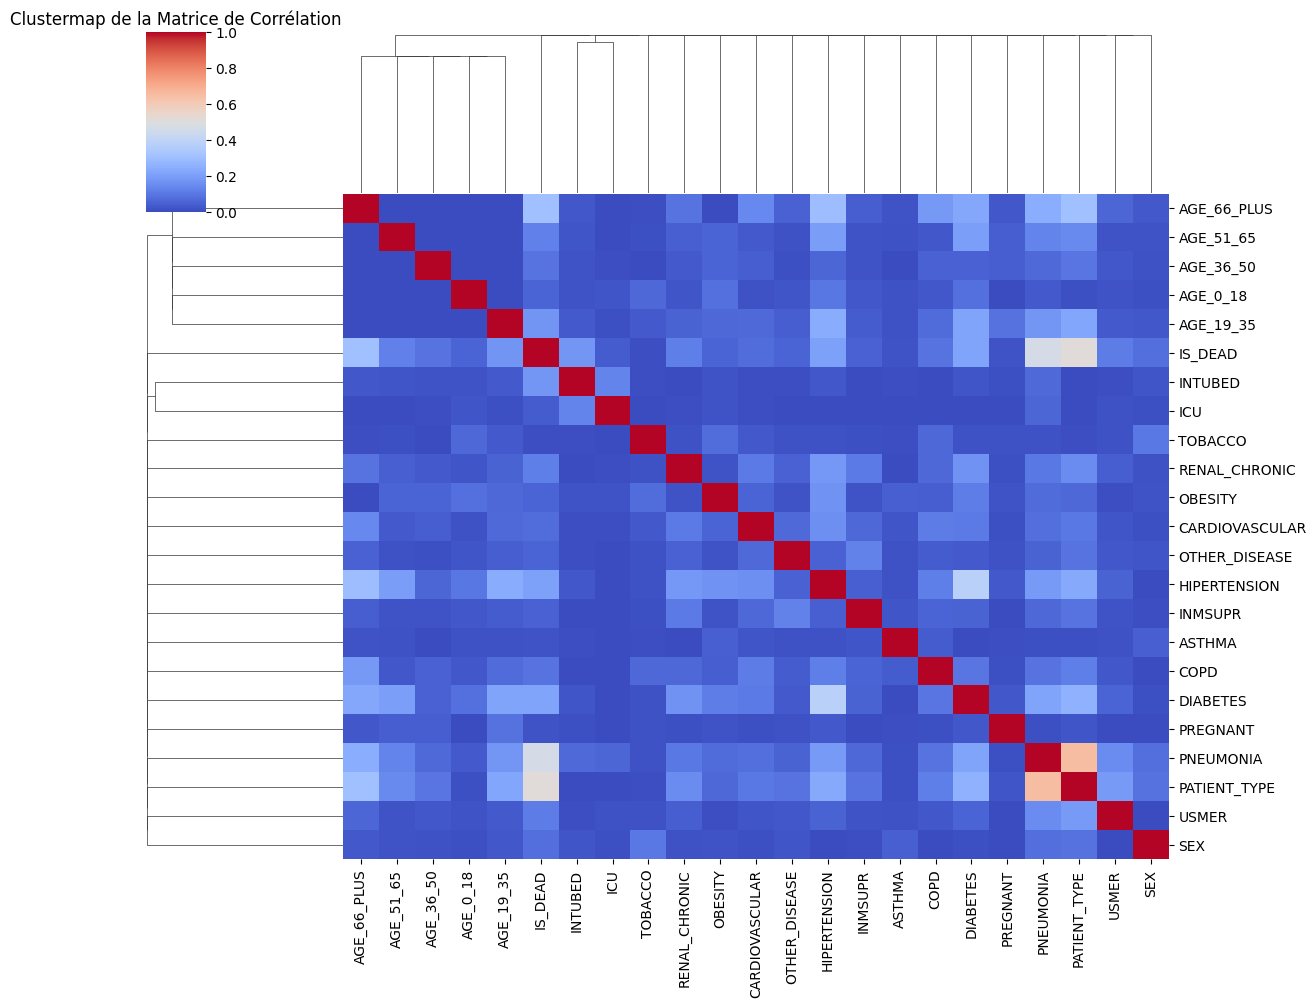

In [54]:
corr_matrix_modified = corr_matrix.copy()

age_related_vars = ['AGE_0_18', 'AGE_19_35', 'AGE_36_50', 'AGE_51_65', 'AGE_66_PLUS']  
for i in age_related_vars:
    for j in age_related_vars:
        if i != j:
            corr_matrix_modified.loc[i, j] = 0
            corr_matrix_modified.loc[j, i] = 0
sns.clustermap(corr_matrix_modified, 
                cmap='coolwarm', 
                annot=False,      
                figsize=(12, 10),
                metric='hamming',  
                method='average'    
                )       

plt.title("Clustermap de la Matrice de Corrélation")
plt.show()


In [55]:
df_normalized = df_copy.copy()
#df_sample = df_normalized.sample(n=1000, random_state=1)
df_sample = df_normalized.dropna().head(2000)

numeric_columns = df_sample.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler()
df_sample[numeric_columns] = scaler.fit_transform(df_sample[numeric_columns])
dissimilarity_matrix = pairwise_distances(df_sample[numeric_columns], metric='cosine')
dissimilarity_df = pd.DataFrame(dissimilarity_matrix, index=df_sample.index, columns=df_sample.index)
print("Matrice de dissimilarité :")
print(dissimilarity_df)


Matrice de dissimilarité :
          5         8             9         16            56        57     \
5      0.000000  0.000183  4.281953e-01  0.404218  3.961958e-01  0.046680   
8      0.000183  0.000000  4.286473e-01  0.410700  3.995090e-01  0.047230   
9      0.428195  0.428647  1.110223e-16  0.439431  4.153320e-01  0.415064   
16     0.404218  0.410700  4.394315e-01  0.000000  3.738178e-01  0.390299   
56     0.396196  0.399509  4.153320e-01  0.373818  1.110223e-16  0.299289   
...         ...       ...           ...       ...           ...       ...   
20650  0.614635  0.620357  6.451837e-01  0.289341  4.963525e-01  0.509712   
20651  0.399460  0.400143  6.918507e-01  0.664082  5.775773e-01  0.341268   
20653  0.621023  0.625889  6.471946e-01  0.300795  5.034975e-01  0.514457   
20654  0.623630  0.628173  6.481539e-01  0.305482  5.064568e-01  0.516515   
20655  0.649428  0.654633  6.772187e-01  0.353504  5.418250e-01  0.553979   

          60        61        62        64     .

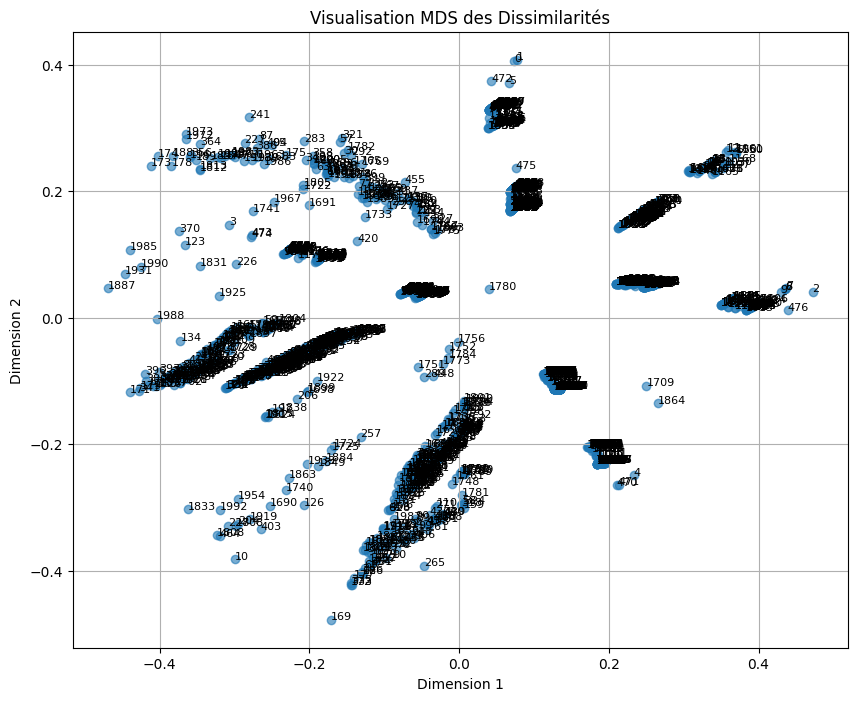

In [56]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
mds_result = mds.fit_transform(dissimilarity_matrix)
plt.figure(figsize=(10, 8))
plt.scatter(mds_result[:, 0], mds_result[:, 1], alpha=0.6)
for i in range(len(mds_result)):
    plt.annotate(i, (mds_result[i, 0], mds_result[i, 1]), fontsize=8)

plt.title('Visualisation MDS des Dissimilarités')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid()
plt.show()


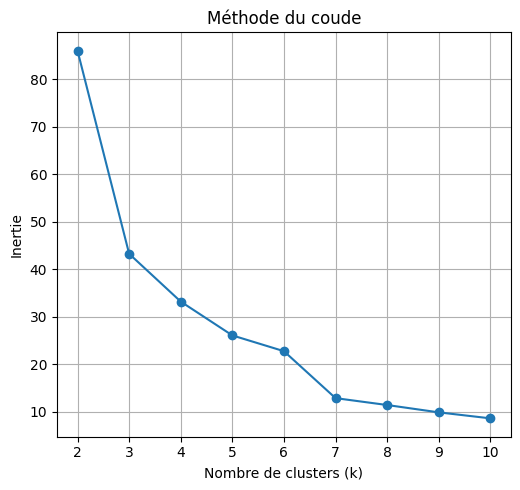

In [11]:
def optimal_k_elbow_silhouette(data, max_clusters=10):
    inertia = []
    silhouette_avg_scores = []
    
    for k in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        
        inertia.append(kmeans.inertia_)

    
    # Affichage de la méthode du coude
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters+1), inertia, marker='o', label='Inertie')
    plt.title('Méthode du coude')
    plt.xlabel('Nombre de clusters (k)')
    plt.ylabel('Inertie')
    plt.grid(True)
    

    plt.tight_layout()
    plt.show()
    
optimal_k = optimal_k_elbow_silhouette(mds_result, max_clusters=10)


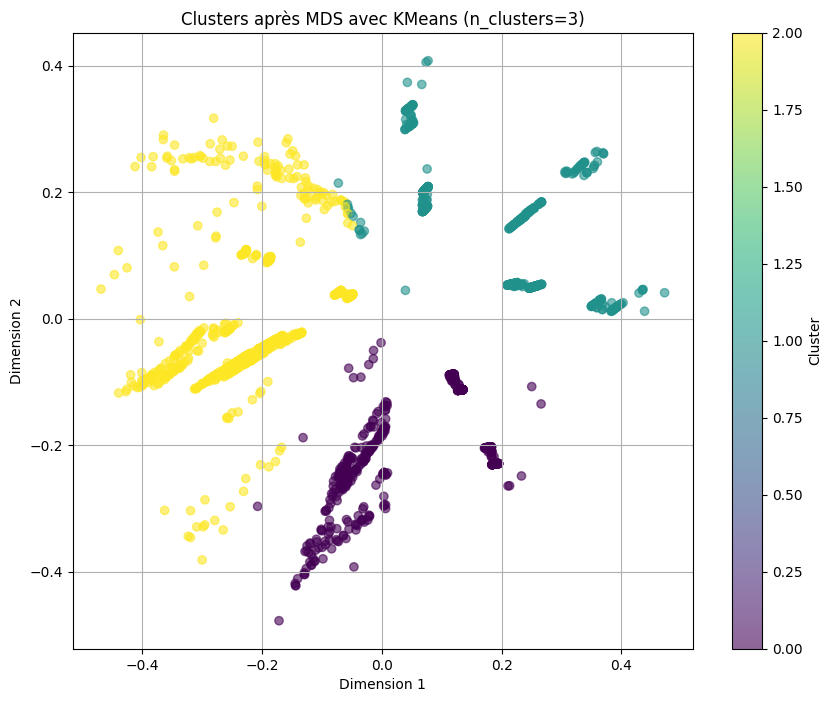

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(mds_result)

# Ajouter les labels des clusters au DataFrame
df_sample['cluster_label'] = labels

# Visualisation des clusters après MDS avec KMeans
plt.figure(figsize=(10, 8))
plt.scatter(mds_result[:, 0], mds_result[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title(f'Clusters après MDS avec KMeans (n_clusters={n_clusters})')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid()
plt.colorbar(label='Cluster')
plt.show()


Indice de silhouette moyen pour n_clusters = 3: 0.500


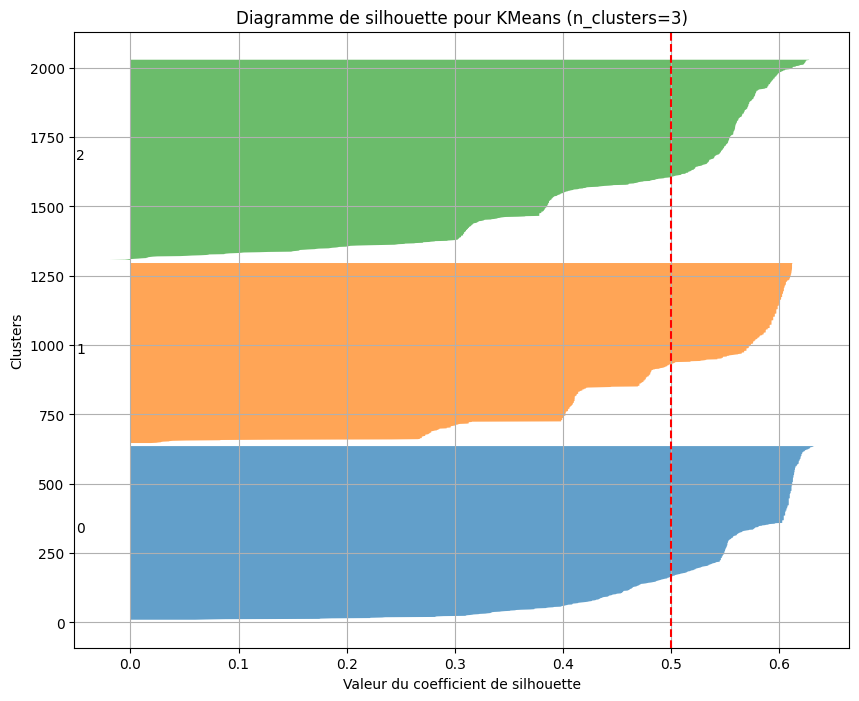

In [13]:
silhouette_avg = silhouette_score(mds_result, labels)
print(f"Indice de silhouette moyen pour n_clusters = {n_clusters}: {silhouette_avg:.3f}")
silhouette_vals = silhouette_samples(mds_result, labels)
plt.figure(figsize=(10, 8))
y_lower = 10  
for i in range(n_clusters):  
    cluster_silhouette_vals = silhouette_vals[labels == i]
    cluster_silhouette_vals.sort()    
    size_cluster = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster, str(i))  # Placer le numéro du cluster
    y_lower = y_upper + 10  # Mise à jour de y_lower pour le prochain cluster
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title(f"Diagramme de silhouette pour KMeans (n_clusters={n_clusters})")
plt.xlabel("Valeur du coefficient de silhouette")
plt.ylabel("Clusters")
plt.grid()
plt.show()

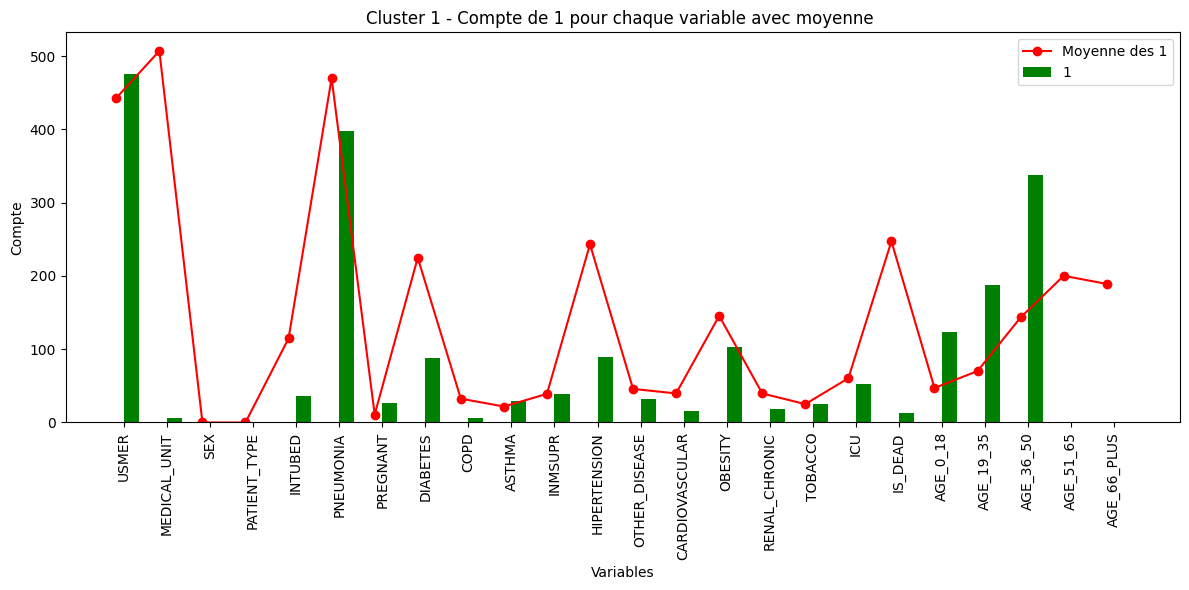

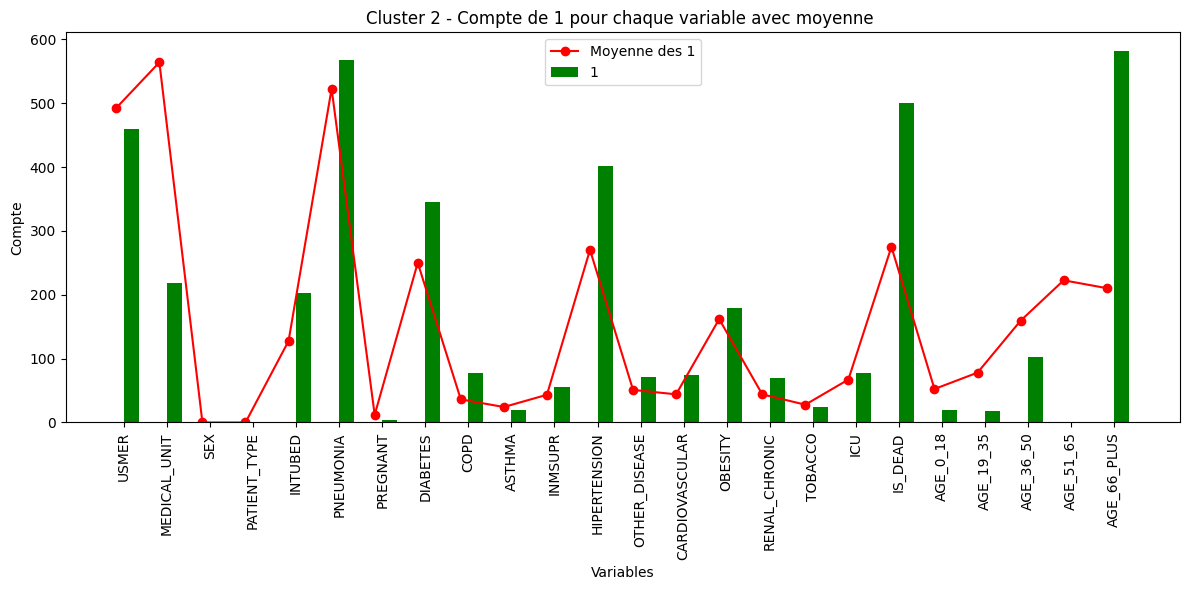

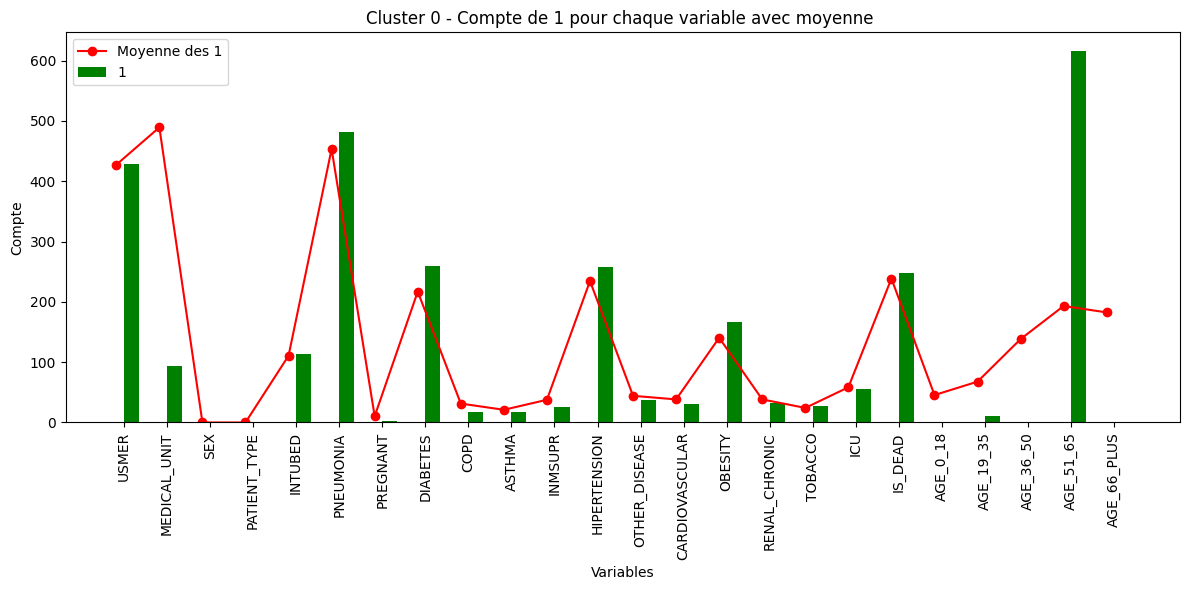

In [37]:

excluded_vars = ['DATE_DIED', 'AGE', 'CLASIFFICATION_FINAL'] 
variables_to_plot = [col for col in df_sample.columns if col not in excluded_vars + ['cluster_label']]

# Calculer la moyenne des 1 pour chaque variable dans df_sample
mean_ones_overall = df_sample[variables_to_plot].mean()

# Création des barplots pour chaque cluster
for cluster in df_sample['cluster_label'].unique():
    cluster_data = df_sample[df_sample['cluster_label'] == cluster]

    # Initialisation de la figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    counts = []  # Stocker les compteurs pour chaque variable
    
    # Calculer les comptes de 0 et 1 pour chaque variable
    for var in variables_to_plot:
        count_0 = (cluster_data[var] == 0).sum()
        count_1 = (cluster_data[var] == 1).sum()
        counts.append([count_0, count_1])
    
    counts = list(zip(*counts)) 
    bar_width = 0.35 
    
    index = range(len(variables_to_plot))
    
    bar_1 = plt.bar([i + bar_width for i in index], counts[1], bar_width, label='1', color='green')

    # Tracer la ligne rouge pour la moyenne des 1 de chaque colonne dans df_sample
    plt.plot(index, mean_ones_overall * len(cluster_data), color='red', linestyle='-', marker='o', label='Moyenne des 1')
    
    # Ajouter des labels, titre, et légende
    plt.xlabel('Variables')
    plt.ylabel('Compte')
    plt.title(f'Cluster {cluster} - Compte de 1 pour chaque variable avec moyenne ')
    plt.xticks([i + bar_width / 2 for i in index], variables_to_plot, rotation=90)
    plt.legend()
    
    # Afficher le graphique
    plt.tight_layout()
    plt.show()